## Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import string
from pathlib import Path

## Reading in the excel

In [2]:
df = pd.read_excel(r'data/input/input_results.xlsx')

### Global variables

In [3]:
rows_len, columns_len = df.shape

print("Rows: " + str(rows_len) + ", Columns: " + str(columns_len))

Rows: 2236, Columns: 671


## Cleaning data set

In [37]:
# Drop all columns with only NAN values
clean_data = df.dropna(axis=1, how='all')

In [38]:
# Remove the consent and extra questions at the end from the survey data
clean_data = clean_data.iloc[:,:417]

### Clean the columns

In [39]:
format_column_names = list(clean_data.columns)

In [40]:
# Sanitize the column names that have "\xa0" in the title
for i in range(len(format_column_names)):
    cur_col_name = format_column_names[i]
    if '\xa0' in cur_col_name:
        format_column_names[i] = (' '.join(cur_col_name.split()))
        

In [41]:
# Sanitize the column names that has the form "* [...]" in the title
for i in range(len(format_column_names)):
    cur_col_name = format_column_names[i]
    if '*' in cur_col_name[0]:
        format_column_names[i] = (cur_col_name.lstrip('* [').replace(']','').replace('[',' ').strip())

In [42]:
duplicate_counter = 0
seen_list = []

for i in range(len(format_column_names)):
    cur_col_name = format_column_names[i]
    if(not(cur_col_name in seen_list)):
        seen_list.append(cur_col_name)
    else:
        # Encountered a duplicate column name, hence increment
        duplicate_counter += 1
        
        #Replace the current column name with a unique name
        format_column_names[i] = cur_col_name+"_"+str(duplicate_counter)
    

In [43]:
clean_data.columns = format_column_names

#### Remove rows with NAN responses to the important columns

In [44]:
# Drop all rows with NAN values for the three main features
clean_data = clean_data.dropna(axis=0, subset=['Three main features merged (AS, AT, AU)'])

#### Removing irrelevant columns

These were found by manual inspection

In [45]:
irrelevant_columns = []
with open(r'data/input/dental_irrelevant_columns.txt') as input_file:
    for line in input_file:
        irrelevant_columns.append(line.split("\n")[0])

In [46]:
clean_data = clean_data.drop(labels=irrelevant_columns, axis=1)

#### Removing internal calculations

In [47]:
# Read in the column names where there is an internal calculation present
columns_internal_calculation = []

for col in clean_data.columns:
    # Column names starting with '{' are calculations from other cells in the excel
    if col[0] == '{':
        columns_internal_calculation.append(col)
        
# Check if save directory exists and create if not
Path('./data/output/dental_removed_columns').mkdir(parents=True, exist_ok=True)
        
# Save the column names to a local file
pd.DataFrame(columns_internal_calculation).to_csv(
    'data/output/dental_removed_columns/columns_internal_calculation',
    index=False,header=False)

# Remove the columns from the dataFrame
clean_data = clean_data.drop(labels=columns_internal_calculation, axis=1)

# Clear memory
del columns_internal_calculation

#### Remove group time

In [48]:
# Read in the column names where there is an internal calculation present
columns_group_time = []

for col in clean_data.columns:
    # Column names starting with '{' are calculations from other cells in the excel
    if 'Group time:' in col:
        columns_group_time.append(col)
        
# Check if save directory exists and create if not
Path('./data/output/dental_removed_columns').mkdir(parents=True, exist_ok=True)
        
# Save the column names to a local file
pd.DataFrame(columns_group_time).to_csv(
    'data/output/dental_removed_columns/columns_group_time',
    index=False,header=False)

# Remove the columns from the dataFrame
clean_data = clean_data.drop(labels=columns_group_time, axis=1)

# Clear memory
del columns_group_time

#### Comparison of before and after initial data cleaning

In [49]:
print(df.shape)
print(clean_data.shape)

(2236, 671)
(2128, 359)


In [50]:
print("Change in rows: " +
      str(clean_data.shape[0] - df.shape[0]) +
      "\nChange in columns: " +
      str(clean_data.shape[1] - df.shape[1]))

Change in rows: -108
Change in columns: -312


## Exploration

### Nan count per column

In [51]:
bar_chart1_data = rows_len - df.isna().sum()

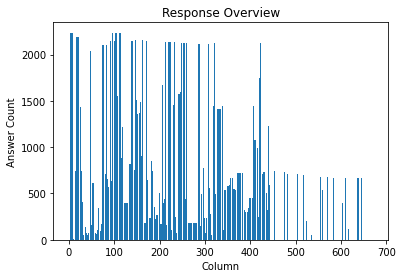

In [52]:
plt.bar(range(len(bar_chart1_data)),bar_chart1_data.values)
plt.title('Response Overview')
plt.xlabel('Column')
plt.ylabel('Answer Count')
plt.show()

In [53]:
bar_chart1_data

Response ID                                2236
Three main features merged (AS, AT, AU)    2128
Date submitted                             2109
Last page                                  2236
Start language                             2236
                                           ... 
Group time: Recommendations                 233
Question time: RECOM                          0
Question time: RECOMWHYYES                    0
Question time: RECOMWHYNOT                    0
Question time: MISSING                        0
Length: 671, dtype: int64

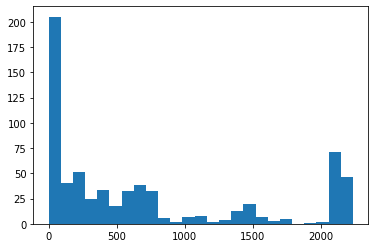

In [54]:
plt.hist(bar_chart1_data, bins=25)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [64]:
clean_data.isna().sum()

Response ID                                                                                                                                                                                                                     0
Date submitted                                                                                                                                                                                                                 73
Last page                                                                                                                                                                                                                       0
Start language                                                                                                                                                                                                                  0
Date started                                                                                    

In [67]:
bar_chart2_data.sort_values()

Other                                                                                                   0.002350
Please specify your gender.                                                                             0.002350
Do you have any remarks regarding the daily course of your chief complaint? Please enter them below.    0.003289
Percentage of pension                                                                                   0.023496
Time set aside for household activities in percentage (%)                                               0.023496
                                                                                                          ...   
Please describe your chief complaint for which you seek consultation:                                   1.000000
Start language                                                                                          1.000000
Date started                                                                                    

In [111]:
bar_chart2_data = clean_data.shape[0] - clean_data.isna().sum()
bar_chart2_data = bar_chart2_data.sort_values(ascending=False) / clean_data.shape[0]

In [116]:
len(bar_chart2_data)

359

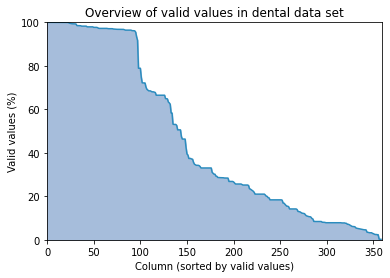

In [134]:
# Description of plot
plt.title('Overview of valid values in dental data set')
plt.xlabel('Column (sorted by valid values)')
plt.ylabel('Valid values (%)')

# Plot the line
plt.plot(range(len(bar_chart2_data)),bar_chart2_data.values*100, color='#2b8cbe')

# Shade the area below the plotted line
plt.fill_between(
    np.arange(0,len(bar_chart2_data)),
    np.zeros(len(bar_chart2_data)),
    bar_chart2_data.values*100,
    color='#a6bddb'
)

# Adjusted settings for visual clarity
plt.ylim([0,100])
plt.xlim([0,len(bar_chart2_data)])

# Check if save directory exists and create if not
Path('./visualization').mkdir(parents=True, exist_ok=True)

plt.savefig('visualization/dental_valid_values.png', dpi=600)

plt.show()

## Finding types of responses

In [136]:
col_types = clean_data.dtypes.astype('string')

In [137]:
pie_chart1_data = col_types.value_counts(dropna=False)

In [138]:
pie_chart1_data.index

Index(['object', 'float64', 'int64'], dtype='string')

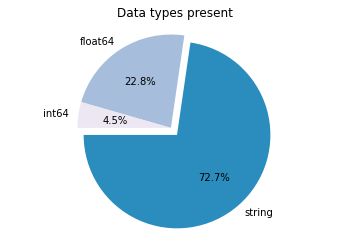

In [139]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['string', 'float64', 'int64']
sizes = pie_chart1_data.values
explode = (0.1, 0, 0)

#add colors
colors = ['#2b8cbe','#a6bddb','#ece7f2']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=180, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title("Data types present")


# Check if save directory exists and create if not
Path('./visualization').mkdir(parents=True, exist_ok=True)

plt.savefig('visualization/dental_data_types.png', dpi=600)

plt.show()

In [84]:
clean_data['Start language'].value_counts()

de       2035
en         63
pt-BR      29
th          1
Name: Start language, dtype: int64

In [89]:
clean_data.where(clean_data['Start language'] == 'th')

,Response ID,Date submitted,Last page,Start language,Date started,Date last action,Gender,Please specify your gender.,Please indicate your age in years.,Height in cm,...,"Haben Sie bezüglich Ihrer Beschwerden Unrecht erfahren? (z. B. Fehlinformation, Fehlbehandlung, ungerechtfertigte Kosten etc.)","Wie stark beeinträchtigt Ihre Erkrankung Ihr Leben? (0 = überhaupt nicht, 10 = sehr stark)","Wie lange meinen Sie, dass Ihre Krankheit noch andauern wird? (0 = nur noch ganz kurz, 10 = für immer)","Wie stark meinen Sie, Ihre Krankheit selbst kontrollieren zu können? (0 = absolut keine Kontrolle, 10 = extreme Kontrolle)","Wie stark meinen Sie, dass Ihre Behandlung bei Ihrer Erkrankung helfen kann? (0 = überhaupt nicht, 10 = extrem hilfreich)","Wie stark spüren Sie Beschwerden durch Ihre Krankheit? (0 = überhaupt nicht, 10 = viele starke Beschwerden)","Wie stark machen Sie sich Sorgen über Ihre Krankheit? (0 = überhaupt keine, 10 = extreme Sorgen)","Wie gut meinen Sie, Ihre Krankheit zu verstehen? (0 = überhaupt nicht, 10 = sehr klar)","Wie stark sind Sie durch Ihre Krankheit gefühlsmäßig beeinträchtigt? (Sind Sie durch Ihre Krankheit zum Beispiel ärgerlich, verängstigt, aufgewühlt oder niedergeschlagen?) (0 = überhaupt nicht, 10 = extrem betroffen)",Is there anything else you want to tell us before you complete this survey?
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
condition = (clean_data['Start language'] == 'en')
example123 = clean_data[condition]

In [98]:
for a in example123.values:
    print(a)

[131 '2017-05-03 01:50:49' 47 'en' '2017-05-03 00:55:38'
 '2017-05-03 01:50:49' 'weiblich' nan 39.0 155.0 45.0 'Nein' 'Nein' 'Nein'
 'Ja' 'Nein' nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 100.0 '0000-00-00 00:00:00'
 'My jaw is out, i cant open my mouth to much. Its always making clik when i eat something'
 'When my mouth is close' 'Help me with this pain' 'Eating' 'Mouth close'
 'spontan' nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 0.0 0.0 0.0 0.0 0.0 0.0 0.0 nan nan 'permanent'
 nan nan nan nan 4.0 7.0 0.0 'Nein' nan nan 'überhaupt nicht' 0 0 'stark'
 1 2 'überhaupt nicht' 0 0 'stark' 1 2 nan 0 0 nan 0 0 nan 0 0 nan ' ' nan
 nan nan nan nan nan nan nan nan nan nan nan nan 'Nein' 'Nein' 'Nein'
 'stark' 'stark' 'stark' 'stark' 'nein' 'nein' 'Rechtsseitig'
 'Rechtsseitig' 'Nein' 'mässig' 'überhaupt nicht' 'überhaupt nicht'
 'mässig' 'überhaupt nicht' 'überhaupt nicht' 'überhaupt nicht'
 'überhaupt nicht' 'mässig'

In [35]:
unique_types = np.array(col_types.unique())

In [36]:
column_index_list = list(range(0,len(col_types)))

# Declare an empty list
index_type_list = []

for type_name in unique_types:
    temp_list = []
    for i in range(0,len(column_index_list)):
        current = col_types[column_index_list[i]]
        if current == type_name:
            temp_list.append(col_types.index[i])
            
    index_type_list.append(temp_list)
    
    del temp_list


In [37]:
types_dict = dict(zip(unique_types, np.arange(0,len(unique_types))))

In [38]:
types_dict

{'int64': 0, 'object': 1, 'float64': 2}

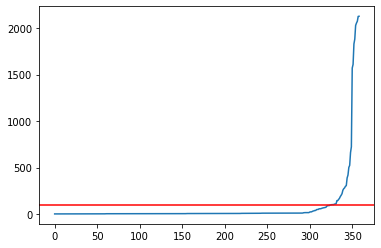

In [39]:
plt.plot(range(len(clean_data.nunique().values)),clean_data.nunique().sort_values())
plt.axhline(y = 100, color = 'r', linestyle = '-')
plt.show()

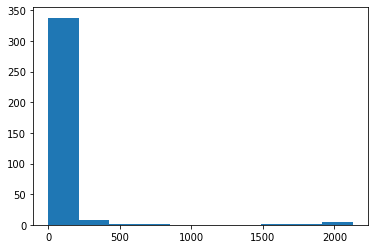

In [40]:
plt.hist(clean_data.nunique())
plt.show()

In [41]:
# Create a list of indicies that points to the first non nan value in a column
valid_index_list = []
for i in range(len(clean_data.columns)):
    valid_index_list.append(clean_data.iloc[:,i].first_valid_index())


In [42]:
# Create a list filled with the first entry in each column that is non nan
first_valid_entry_list = []

for j in range(len(clean_data.columns)):
    cur_index = valid_index_list[j]
    print(clean_data.iloc[cur_index,j])

27
2019-11-28 12:06:00
48
de
2019-11-28 11:41:00
2019-11-28 12:06:00
Male
männlich
60.0
176.0
70.0
nan
Yes
Yes
nan
Yes
nan
Yes
nan
Yes
100.0
nan
100.0
nan
50.0
Yes
nan
ich bin nicht Arbeitsunfähig
50.0
2019-11-01 00:00:00
sometimes
nein
nan
nan
nan
nan
Schmerzen im Kiefergelenk
Essen
Schmerzfreiheit
essen vor allem harte, zähe Speisen, wenn das Kissen gegen den Kiefer drückt
wenn der Kiefer entspannt ist
by event (accident, physical / emotional stress, dental / medical treatment, operation, illness)
nan
Yes
Yes
nan
nan
Nein
nan
Sturz mit Velo
2019-11-05 00:00:00
versuchte eine Nuss mit den Zähnen zu öffnen
2019-11-05 00:00:00
nan
nan
nan
nan
nan
nan
nan
nan
nan
2020-01-23 00:00:00
less than 3 months
4.0
1.0
5.0
1.0
5.0
1.0
0.0
0.0
my pain changes that much that it is difficult to show with this rulers.
attacks
3.0
0.0
more than 2 Minuten up to half an hour
essen
4.0
7.0
1.0
No
nan
nan
not at all
0
0
not at all
0
0
a lot
1
2
not at all
0
0
not at all
0
0
left
0
0
left
0
0
not at all
0
0

In [43]:
clean_data['Other']

0                                NaN
1                                NaN
3                                NaN
6       ich bin nicht arbeitsunfähig
7           Bin nicht Arbeitsunfähig
                    ...             
2230                             NaN
2232                             NaN
2233                             NaN
2234                             NaN
2235                             NaN
Name: Other, Length: 2128, dtype: object

## Dictionary with values

In [44]:
entries_dict = {}

for column in clean_data.columns:
    entries_array = clean_data[column].unique()
    
    for entry in entries_array:
        if(entry in entries_dict):
            entries_dict[entry] += 1
        else:
            entries_dict[entry] = 1
        
del entries_array

#### Determining unique types

In [45]:
list(entries_dict.keys())

[27,
 28,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 55,
 57,
 58,
 59,
 61,
 62,
 63,
 64,
 67,
 68,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 85,
 86,
 87,
 89,
 91,
 92,
 93,
 94,
 95,
 97,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 107,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 150,
 151,
 153,
 154,
 156,
 157,
 158,
 159,
 162,
 164,
 166,
 167,
 169,
 170,
 171,
 173,
 174,
 175,
 176,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 194,
 195,
 196,
 198,
 199,
 200,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 2

In [46]:
entries_dict[np.nan]

256

### Seperating the date time from the object types in the index_type_list

In [47]:
test = {}
for key in entries_dict:
    if type(key) in test:
        test[type(key)] += 1
    else:
        test[type(key)] = 1

In [48]:
test

{numpy.int64: 1582, str: 20409, float: 1, numpy.float64: 132, int: 1}

In [49]:
for key in entries_dict:
    if type(key) == str:
        print(key)

2019-11-28 12:06:00
2019-11-28 15:19:00
2019-12-03 11:15:00
2019-12-12 00:05:31
2019-12-10 20:59:00
2019-12-16 17:40:05
2019-12-12 12:40:00
2019-12-13 09:50:00
2019-12-13 10:25:00
2019-12-13 14:04:15
2019-12-16 20:03:20
2019-12-17 11:49:08
2019-12-17 10:56:54
2019-12-17 16:27:15
2019-12-21 07:33:49
2019-12-18 22:20:54
2019-12-19 21:45:26
2019-12-22 13:35:53
2019-12-22 15:25:56
2019-12-22 21:40:06
2020-01-06 09:19:31
2020-01-02 21:28:51
2020-01-02 23:18:36
2020-01-03 00:17:18
2020-01-09 18:03:10
2020-01-13 18:44:47
2020-01-16 15:51:46
2020-05-09 17:39:56
2020-01-18 17:55:55
2020-01-19 14:09:04
2020-01-20 16:23:49
2020-02-02 21:34:24
2020-01-21 19:23:36
2020-01-21 16:44:26
2020-01-22 20:22:17
2020-01-23 11:49:09
2020-01-23 11:06:52
2020-01-23 18:26:28
2020-01-24 14:28:43
2020-01-25 13:32:52
2020-05-12 21:00:00
2020-01-26 13:27:24
2020-02-09 20:01:09
2020-01-27 10:53:18
2020-01-27 19:27:24
2020-01-30 14:47:35
2020-01-31 10:16:56
2020-01-31 13:51:50
2020-02-01 12:11:46
2020-02-02 12:04:08


In [50]:
# Method for searching the value in the dataset
for i in range(0,len(clean_data.columns)):
    for j in range(0,len(clean_data)):
        if('April 2019 bis September 2019' == clean_data.iloc[j,i]):
            print(i,j,clean_data.columns[i])

In [44]:
#TODO remove date-time entry from the index_type_list[1] (object) to a new place in that list

In [51]:
date_column_list = []

# Method for searching the value in the dataset
for i in range(0,len(clean_data.columns)):
    for j in range(0,len(clean_data)):
        cur_value = clean_data.iloc[j,i]
        try:
            datetime.datetime.strptime(str(cur_value), '%Y-%m-%d %H:%M:%S')
            date_column_list.append(clean_data.columns[i])
            break
        except ValueError:
            pass

In [52]:
index_type_list.append(date_column_list)
types_dict['datetime'] = 3

for col_name in date_column_list:
    index_type_list[types_dict['object']].remove(col_name)

In [53]:
index_type_list[1]

['Start language',
 'Gender',
 'Please specify your gender.',
 'Current or latest occupation [in training ]',
 'Current or latest occupation [working (occupation, household)]',
 'Current or latest occupation [unable to work]',
 'Current or latest occupation [unemployed]',
 'Current or latest occupation [retired]',
 'employed',
 'self-employed',
 'houseman / housewife',
 'illness',
 'accident',
 'Other',
 'Is there an open or closed application for a pension?',
 'Pension claim or pension because of:',
 'Please describe your chief complaint for which you seek consultation:',
 'What does your chief complaint stop you from doing?',
 'What do you expect as the result of the examinations and treatments in our clinic?',
 'Which factors aggravate your complaints?  (e.g. chewing hard / soft food, biting, drinking, mouth opening (e.g. yawning), talking, physical / emotional stress, playing a musicial instrument, ... )',
 'Which factors alleviate your complaints? (e.g. distraction, rest, relaxati

In [54]:
column_response_amounts = clean_data[index_type_list[types_dict['object']]].nunique().sort_values()

In [55]:
text_columns = list(column_response_amounts.index[np.where(column_response_amounts > 16)])
text_columns.reverse()

In [57]:
column_response_amounts[-32:]

Do you have any remarks regarding the your medication intake? Please enter them below.                                                                                                                    48
Pension claim or pension because of:                                                                                                                                                                      57
After which physical stress did your chief complaint start?                                                                                                                                               62
Nach welcher Operation traten Ihre Schmerzen auf?                                                                                                                                                         67
Which other treatment was performed to you?                                                                                                                                         

In [58]:
for col_name in index_type_list[1]:
    print(clean_data.loc[clean_data[col_name].first_valid_index(),col_name])

de
Male
weiblich
No
Yes
Yes
No
Yes
Yes
No
Yes
Yes
No
ich bin nicht arbeitsunfähig
sometimes
es ist keine Rente beantragt
Schmerzen im Kiefergelenk
Essen
Schmerzfreiheit
essen vor allem harte, zähe Speisen, wenn das Kissen gegen den Kiefer drückt
wenn der Kiefer entspannt ist
by event (accident, physical / emotional stress, dental / medical treatment, operation, illness)
Yes
Yes
No
No
Nein
No
Sturz mit Velo
versuchte eine Nuss mit den Zähnen zu öffnen
keine seelische Belastung ich und keinen Stress: gleiches Systemproblem wie oben => fiktives Datum in nächtem Feld
keine zahnärztliche Behandlung: gleiches Systemproblem wie oben => fiktives Datum
Kariesbehandlung
keine Krankheit gleichzeitig
Alles rechts: zuerst die Ohrschmerzen (Juli), dann zusätzlich  die Unterkieferschmerzen(ab Ende August), dann Schädelschmerzen. (ab Mitte Oktober)
Am Anfang nicht jeden Tag. Seit Anfang November leider jeden Tag.
less than 3 months
my pain changes that much that it is difficult to show with this ruler

In [59]:
# Remove certain columns from the text_columns due to unneeded information
text_columns.remove('Pension claim or pension because of:')
text_columns.remove('Do you have any remarks regarding the your medication intake? Please enter them below.')
text_columns.remove('To whom do you feel to be a burden?')


In [60]:
# Select the columns from the data set with text entries in the columns (and unique entries > 16)
text_clean_data = clean_data[text_columns]

In [61]:
text_clean_data.isnull().sum().sum()

45396

In [62]:
text_clean_data.shape

(2128, 29)

In [63]:
chart3_data_unique = text_clean_data.nunique() / text_clean_data.shape[0]
chart3_data_nan = text_clean_data.isna().sum() / text_clean_data.shape[0]

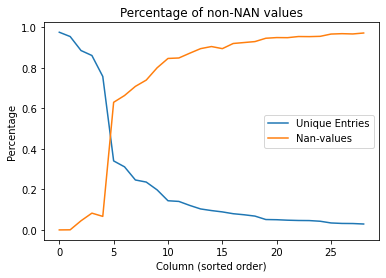

In [64]:
x_range = range(len(chart3_data_nan))

plt.plot(x_range, chart3_data_unique.values, label="Unique Entries")
plt.plot(x_range, chart3_data_nan.values, label="Nan-values")
plt.title('Percentage of non-NAN values')
plt.xlabel('Column (sorted order)')
plt.ylabel('Percentage')
plt.legend(loc='best')

plt.show()

In [65]:
text_clean_data.iloc[:,:5].isna().sum().sum()

415

In [66]:
text_clean_data

,Please describe your chief complaint for which you seek consultation:,What do you expect as the result of the examinations and treatments in our clinic?,"Which factors aggravate your complaints? (e.g. chewing hard / soft food, biting, drinking, mouth opening (e.g. yawning), talking, physical / emotional stress, playing a musicial instrument, ... )",What does your chief complaint stop you from doing?,"Which factors alleviate your complaints? (e.g. distraction, rest, relaxation, keeping jaw in fixed position, ... )",What do the restrictions selected above mean in terms of your eating habits?,What was/were the diagnosis/diagnoses of your chief complaint(s)?,"In your personal opinion, which diagnosis best explains your chief complaints?",Complaint attacks are triggered by the folllowing (please name all you can remember):,Please give a brief description of the life events that are bothering you.,...,"I suffer from the following disorders / complaints, for which I do not take any medication:",Which other mouth/jaw related habits did you observe?,After which accident did your chief complaint start?,Please give a brief description of the other quality of your pain at the onset of your illness.,After which illness did your chief complaint start?,After which emotional stress did your chief complaint start?,Do you have any remarks regarding your pain in the torso? Please enter them below.,Which other treatment was performed to you?,Nach welcher Operation traten Ihre Schmerzen auf?,After which physical stress did your chief complaint start?
0,Schmerzen im Kiefergelenk,Schmerzfreiheit,"essen vor allem harte, zähe Speisen, wenn das ...",Essen,wenn der Kiefer entspannt ist,muss vor allem weiche oder flüssige Speisen zu...,NaN,NaN,essen,NaN,...,NaN,NaN,Sturz mit Velo,NaN,NaN,NaN,NaN,NaN,NaN,versuchte eine Nuss mit den Zähnen zu öffnen
1,Headache,less pain,"physical activity, stress",Problems with concentration and sleep,"distraction, rest",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Kiefergelenkschmerzen,wieder normal kauen können,Essen,essen ist mühsam,wenn ich den Kiefer ruhig lasse,ernähre mich vor allem flüssig oder nur weiche...,NaN,NaN,essen,NaN,...,NaN,NaN,Sturz beim Joggen,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Schmerzen rechts: Ohr, unter Kiefer, rechte Sc...",Das Herausfinden einer kausale Ursache. Falls ...,Die Schmerzen erhöhen sich im Laufe des Tages,"Sport, Konzentration und immer mehr Probleme z...",Liegen Schlafen,NaN,NaN,NaN,NaN,NaN,...,NaN,mein Kiefer ist häufig gespannt. Ich weiss nic...,hatte keinen Unfall : Systemproblem. kann nic...,einfacher dumpfer Ohrweh,keine Krankheit gleichzeitig,keine seelische Belastung ich und keinen Stres...,NaN,NaN,NaN,Beschwerden sind nach keinen körperlichen Bela...
7,Kieferbeschwerden nach Sturz,Volle Genesung,"Kauen harter Speisen, zulanges öffnen und schl...",Ich kann manchmal schlecht kauen,Schmerztabletten für mehrere Tage,NaN,keine,keine,NaN,NaN,...,NaN,NaN,Nach Sturz aufs Gesicht,erschwerend,nach dem Sturz,keine seelische Belastung,NaN,NaN,NaN,nach dem Sturz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230,Meine Mundöffnung ist eingeschränkt und schmer...,"Schmerzfreies, weites Öffnen","weites öffnen des Mundes (Gähnen auch), Kauen ...",NaN,"Chiropraktiker, Linderung jedoch nur für 3-4 Tage",NaN,NaN,"Ich weiss es nicht, da ich kein Arzt bin.",NaN,NaN,...,keine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,keine Operation,NaN
2232,"Aufbissprobleme durch Zahnfehlstellung, Schmer...",Korrektur des Problems um keine Schienen und S...,"Langes sprechen,kauen",NaN,Saroten 10mg auf die Nacht um schlafen zu können.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2233,Seit Jahren starke Schmerzen im Bereich des Oh...,Die Ursache für meine Beschwerden herauszufinden,"Konstanter Schmerz über Stunden, deswegen ist ...",NaN,"Atemübungen helfen, aber nur, damit ich mich n...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223

In [67]:
top_response_columns = [
    'Please describe your chief complaint for which you seek consultation:',
    'What do you expect as the result of the examinations and treatments in our clinic?',
    'Which factors aggravate your complaints?  (e.g. chewing hard / soft food, biting, drinking, mouth opening (e.g. yawning), talking, physical / emotional stress, playing a musicial instrument, ... )',
    'What does your chief complaint stop you from doing?',
    'Which factors alleviate your complaints? (e.g. distraction, rest, relaxation, keeping jaw in fixed position, ... )',
]

In [68]:
text_clean_data.nunique()

Please describe your chief complaint for which you seek consultation:                                                                                                                                   2074
What do you expect as the result of the examinations and treatments in our clinic?                                                                                                                      2029
Which factors aggravate your complaints?  (e.g. chewing hard / soft food, biting, drinking, mouth opening (e.g. yawning), talking, physical / emotional stress, playing a musicial instrument, ... )    1882
What does your chief complaint stop you from doing?                                                                                                                                                     1830
Which factors alleviate your complaints? (e.g. distraction, rest, relaxation, keeping jaw in fixed position, ... )                                                                  

In [62]:
top_text_clean_data = text_clean_data[top_response_columns]

In [63]:
# Save the DataFrame to a local file
pd.DataFrame(top_text_clean_data).to_csv('top_text_clean_data_all')

# Save the values to a local file
pd.DataFrame(top_text_clean_data).to_csv('top_text_clean_data', index=False,header=False)

In [64]:
# Save the DataFrame to a local file
pd.DataFrame(text_clean_data).to_csv('text_clean_data_all')

# Save the values to a local file
pd.DataFrame(text_clean_data).to_csv('text_clean_data', index=False,header=False)

In [195]:
sentences_text_clean_data = list(text_clean_data.to_numpy(na_value="").flatten())

In [196]:
sentences_list = []

for entry in sentences_text_clean_data:
    if(
        not(entry == "") and not(entry == ".") and not(entry == "/") and not(entry == "-")
        and not(entry == "--") and not(entry == "---") and not(entry == "----") and not(entry == "-----")
        and not(entry == "------") and not(entry == "-------") and not(entry == "?")
      ):
        sentences_list.append(entry)

In [197]:
# Replacing "\n" by " " so that parsing to txt works well
for i in range(len(sentences_list)):
    if(not type(sentences_list[i]) == str):
        sentences_list[i] = str(sentences_list[i])
    
    sentences_list[i] = sentences_list[i].lower()
        
    if("\n" in sentences_list[i]):
        sentences_list[i] = sentences_list[i].replace("\n"," ")

In [74]:
import nltk
from tqdm import tqdm

In [75]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/thesis-
[nltk_data]     server1/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/thesis-
[nltk_data]     server1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [198]:
from nltk.tokenize import word_tokenize

for i in tqdm(range(len(sentences_list))):
    sentences_list[i] = word_tokenize(sentences_list[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16165/16165 [00:01<00:00, 9953.70it/s]


In [199]:
sentences_list

[['schmerzen', 'im', 'kiefergelenk'],
 ['schmerzfreiheit'],
 ['essen',
  'vor',
  'allem',
  'harte',
  ',',
  'zähe',
  'speisen',
  ',',
  'wenn',
  'das',
  'kissen',
  'gegen',
  'den',
  'kiefer',
  'drückt'],
 ['essen'],
 ['wenn', 'der', 'kiefer', 'entspannt', 'ist'],
 ['muss',
  'vor',
  'allem',
  'weiche',
  'oder',
  'flüssige',
  'speisen',
  'zu',
  'mir',
  'nehmen'],
 ['essen'],
 ['nein', ',', 'was', 'alles', 'ok'],
 ['sturz', 'mit', 'velo'],
 ['versuchte', 'eine', 'nuss', 'mit', 'den', 'zähnen', 'zu', 'öffnen'],
 ['headache'],
 ['less', 'pain'],
 ['physical', 'activity', ',', 'stress'],
 ['problems', 'with', 'concentration', 'and', 'sleep'],
 ['distraction', ',', 'rest'],
 ['pain', 'not', 'always', 'on', 'both', 'sides', ',', 'but', 'most', 'often'],
 ['this', 'pain', 'bothers', 'me', 'a', 'lot'],
 ['everything', 'covered'],
 ['kiefergelenkschmerzen'],
 ['wieder', 'normal', 'kauen', 'können'],
 ['essen'],
 ['essen', 'ist', 'mühsam'],
 ['wenn', 'ich', 'den', 'kiefer', 'ru

In [200]:
for i in tqdm(range(len(sentences_list))):
    sentence = sentences_list[i]
    
    filter_sentence = []
    
    for word in sentence:
        if not word in string.punctuation:
            if not word in stopwords.words():
                filter_sentence.append(word)

    sentences_list[i] = filter_sentence

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16165/16165 [08:56<00:00, 30.15it/s]


In [208]:
# Writing the responses to a txt file
with open('data/sentences_text_clean_data.txt', 'w') as f:
    for sentence in sentences_list:
        # Check for empty sentences
        if not sentence == []:
            f.write("%s\n" % sentence)